# Trying things out with PyMC3 Part 2 Copy 1

## Generating observations

For our test problem, we'll do a three-parameter model which fits a straight line to data. The parameters will be the slope, the intercept, and the scatter about the line; the scatter in this case will be treated as a nuisance parameter.

$\hat{y} = f(x | \alpha, \beta) = \alpha x_i + \beta$


with Gaussian noise on the observed values,

$ P(x_i, y_i | \alpha, \beta, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp [\frac{-(y_i - \hat{y_i})^2}{2\sigma^2}] $

$ \forall i$, likelihood function becomes:

$ P(x, y | \alpha, \beta, \sigma) = (2\pi\sigma^2) ^ {-N/2} \exp [\frac{1}{2\sigma^2} \sum_{i=1}^{N} -(y_i - \hat{y_i})^2] $

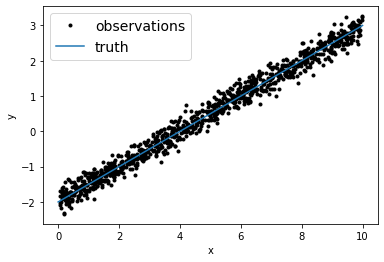

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# slope, intercept, variance
true_params = np.array([0.5, -2, 0.2])

N = 1000
t = np.linspace(0, 10, 2)
x = np.random.uniform(0, 10, N) # we are limiting the data generation from 0 to 10
y = x * true_params[0] + true_params[1]
y_obs = y + true_params[-1] * np.random.randn(N)

plt.plot(x, y_obs, ".k", label="observations")
plt.plot(t, true_params[0]*t + true_params[1], label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=14);

## Defining the model in PyMC3

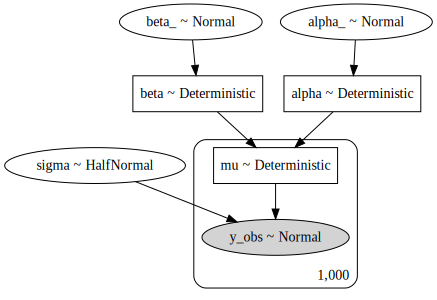

In [11]:
import pymc3 as pm
import theano

x_shared = theano.shared(x)

with pm.Model() as lineFittingModel:
    
    alpha_ = pm.Normal('alpha_', mu=0, sigma=10)
    beta_ = pm.Normal('beta_', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    alpha = pm.Deterministic("alpha", alpha_)
    beta = pm.Deterministic("beta", beta_)
    mu_calc = alpha * x_shared + beta
    mu = pm.Deterministic("mu", mu_calc)
#     mu = 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('y_obs', mu = mu , sigma=sigma, observed=y_obs)
pm.model_to_graphviz(lineFittingModel)

## MAP Estimate

In [ ]:
map_estimate = pm.find_MAP(model=lineFittingModel)

map_estimate

## NUTS Sampler

In [ ]:
with lineFittingModel:
    trace = pm.sample(draws=2000, tune = 2000)

In [ ]:
pm.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'], ref_val=list(true_params), kind="%hist")

In [ ]:
import corner
samples = np.vstack([trace[k] for k in ["alpha", "beta", "sigma"]]).T
corner.corner(samples, truths=true_params);

In [ ]:
pm.plot_trace(trace, var_names=['alpha', 'beta', 'sigma'])

## MCMC

In [ ]:
import theano

f = theano.function(lineFittingModel.vars, [lineFittingModel.logpt] + lineFittingModel.deterministics)
    
def log_prob_func(params):
    dct = lineFittingModel.bijection.rmap(params)
    args = (dct[k.name] for k in lineFittingModel.vars)
    results = f(*args)
    return tuple(results)

In [ ]:
[lineFittingModel.logpt] + lineFittingModel.deterministics

In [ ]:
with lineFittingModel:
    res = pm.find_MAP()

In [ ]:
vec = lineFittingModel.bijection.map(res)

In [ ]:
dct = lineFittingModel.bijection.rmap(vec)

In [ ]:
args = (dct[k.name] for k in lineFittingModel.vars)

In [ ]:
lineFittingModel.observed_RVs

In [ ]:
f2 = theano.function(lineFittingModel.vars, lineFittingModel.)

In [ ]:
import emcee

with lineFittingModel:
    # First we work out the shapes of all of the deterministic variables
    res = pm.find_MAP()
    vec = lineFittingModel.bijection.map(res)
    initial_blobs = log_prob_func(vec)[1:]
    dtype = [(var.name, float, np.shape(b)) for var, b in zip(lineFittingModel.deterministics, initial_blobs)]
    
    # Then sample as usual
    coords = vec + 1e-5 * np.random.randn(25, len(vec))
    nwalkers, ndim = coords.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
    sampler.run_mcmc(coords, 5000, progress=True)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["alpha", "beta", "sigma"]], truths=true_params);

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["alpha", "beta", "logs"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = .3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)